# Binary classifier using esm2 embeddings
----

In [3]:
import math

import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, f1_score
import h5py
import time

import os
from dotenv import load_dotenv
load_dotenv()

from sklearn.utils.class_weight import compute_class_weight
from data_manipulation.reading_util import load_ml_data_emb, load_ml_data_emb_binary
from data_manipulation.reading_util import load_non_enz_esm2

In [4]:
enzyme_csv_path = os.getenv("CSV30_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_30")

non_enzymes_esm2_path = os.getenv("ESM2_NON_ENZYMES")
non_enzymes_fasta_path = os.getenv("FASTA_NON_ENZYMES")


# Load enzymes
X_enzymes, _ = load_ml_data_emb_binary(path_to_esm2=esm2_enzymes_path, path_to_enzyme_csv=enzyme_csv_path)
del _ # delete unused ec_labels


# Load non_enzymes
X_non_enzymes, _ = load_non_enz_esm2(non_enzymes_fasta_path=non_enzymes_fasta_path, non_enzymes_esm2_path=non_enzymes_esm2_path)
del _ # delete unused labels which only fit for multi class classification

y_non_enzymes = np.array([0 for emb in range(len(X_non_enzymes))]) # Append label -1 for len(X_non_enzymes)
y_enzymes = np.array([1 for emb in range(len(X_enzymes))]) # Append label 1 for len(X_enzymes)


LOG:
 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 18 entries will be ignored
Total count:  288
LOG:
 Data loaded in: 1.16 min
LOG:
 ESM2 of enzymes: 9186
LOG:
 Labels of enzymes: 9186
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG:
 17 Sequences with aa U in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG:
 2138 non enzymes are longer than 1022 cutoff
LOG:
 2155 entries will be ignored
LOG:
 Non Enzymes data loaded in: 4.643 min
LOG:
 ESM2 of non enzymes: 37347
LOG:
 Labels of non enzymes: 37347


In [5]:
# Split only enzymes
# X_train_enzymes, X_test_enzymes, y_train_enzymes, y_test_enzymes = train_test_split(X_enzymes, y_enzymes, test_size=0.30, random_state=42)

# duplicate train enzymes
# X_train_enzymes_dup = np.vstack((X_train_enzymes, X_train_enzymes))
# y_train_enzymes_dup = np.hstack((y_train_enzymes, y_train_enzymes))

# duplicate duplicated train enzymes
# X_train_enzymes_quad = np.vstack((X_train_enzymes_dup, X_train_enzymes_dup))
# y_train_enzymes_quad = np.hstack((y_train_enzymes_dup, y_train_enzymes_dup))


# Split non enzymes
# X_train_non_enzymes, X_test_non_enzymes, y_train_non_enzymes, y_test_non_enzymes = train_test_split(X_non_enzymes, y_non_enzymes, test_size=0.30, random_state=42)

# Finally put everything back together
# X_train = np.vstack((X_train_enzymes_quad, X_train_non_enzymes))
# y_train= np.hstack((y_train_enzymes_quad, y_train_non_enzymes))
# X_val = np.vstack((X_test_enzymes, X_test_non_enzymes))
# y_val = np.hstack((y_test_enzymes, y_test_non_enzymes))

X = np.vstack((X_enzymes, X_non_enzymes))
y = np.hstack((y_enzymes, y_non_enzymes))
print(len(X))
print(len(y))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)


# file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/only_enzyme_models/y_train_level_0_lables.txt"
# np.savetxt(file_path, y_train, delimiter=',', fmt='%d')


46533
46533


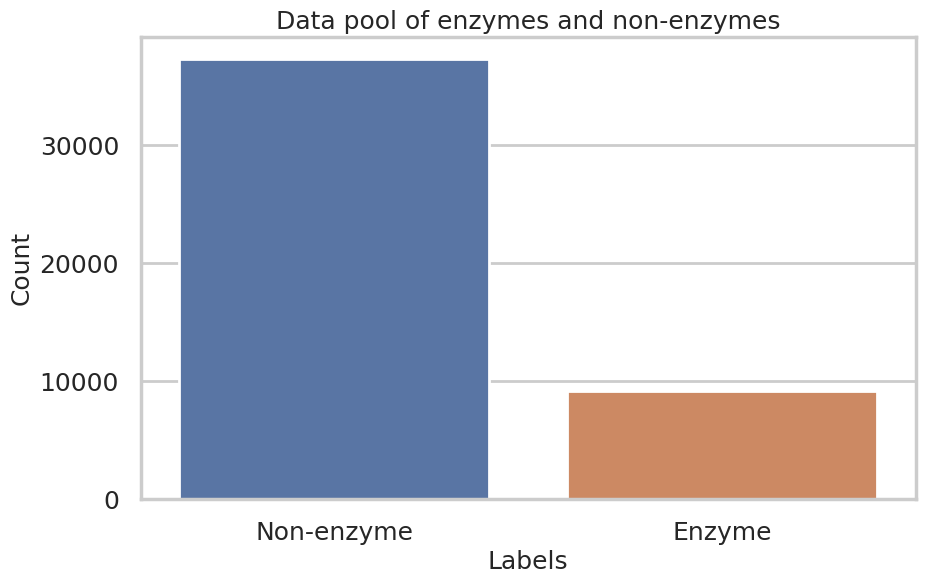

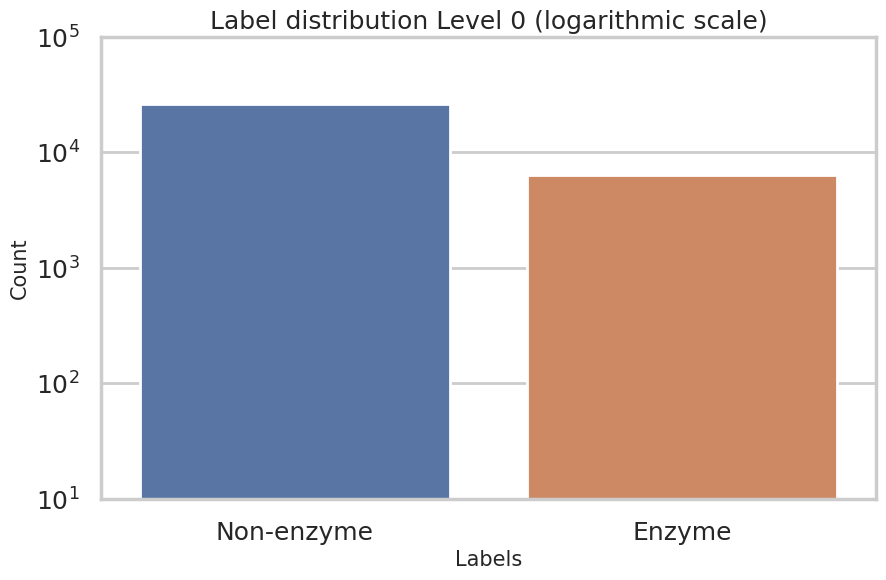

In [9]:

# Plot fore level 0
sns.set_palette("colorblind")
sns.set("poster")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.set_style("whitegrid")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

countplot = sns.countplot(x=y)
countplot.set_xticklabels(countplot.get_xticklabels())
plt.xticks([0, 1], ["Non-enzyme", "Enzyme"])

# Add labels and title
plt.title("Data pool of enzymes and non-enzymes", fontsize=18)
plt.xlabel("Labels", fontsize=18)
plt.ylabel("Count", fontsize=18)

# Show the plot
plt.show()

# Plot fore level 0
sns.set_palette("colorblind")
sns.set("poster")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.set_style("whitegrid")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(10, 100000)  # Adjust the values as needed

countplot = sns.countplot(x=y_train)
countplot.set_xticklabels(countplot.get_xticklabels())
plt.xticks([0, 1], ["Non-enzyme", "Enzyme"])
plt.yscale("log")

# Add labels and title
plt.title("Label distribution Level 0 (logarithmic scale)", fontsize=18)
plt.xlabel("Labels", fontsize=15)
plt.ylabel("Count", fontsize=15)

# Show the plot
plt.show()


In [6]:
def plot_report(report, y_test, predictions):
    """
    Plots results of model
    :param report: Report of model
    """

    class_0_metrics = report.split('\n')[2].split()[1:]
    class_1_metrics = report.split('\n')[3].split()[1:]

    metrics = [class_0_metrics,
               class_1_metrics,
               ]

    precs = []
    recs = []
    f1_s = []

    for class_m in metrics:
        precision = float(class_m[0])
        recall = float(class_m[1])
        f1_score = float(class_m[2])
        precs.append(precision)
        recs.append(recall)
        f1_s.append(f1_score)

    class_names = [0, 1]

    # Create subplots for accuracy, precision, and F1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot accuracy for each class
    ax1.bar(class_names, recs)
    ax1.set_title("Recall")
    ax1.set_xlabel("Class")


    # Plot precision for each class
    ax2.bar(class_names, precs)
    ax2.set_title("Precision")
    ax2.set_xlabel("Class")

    # Plot F1 score for each class
    ax3.bar(class_names, f1_s)
    ax3.set_title("F1 Score")
    ax3.set_xlabel("Class")

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


    conf_matrix = confusion_matrix(y_test, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Optimizing Hyperparams
----

In [8]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 256)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 16, 64)

    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, callbacks=[early_stop], verbose=0)

    # Get the best validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss


In [9]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)


[I 2023-12-15 15:56:40,602] A new study created in memory with name: no-name-b4ac3c20-3cc1-4b31-90e6-17f3e4d1c72b
2023-12-15 15:56:40.960958: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 333547520 exceeds 10% of free system memory.
2023-12-15 15:56:44.924874: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142950400 exceeds 10% of free system memory.
[I 2023-12-15 15:57:16,993] Trial 0 finished with value: 0.17017899453639984 and parameters: {'num_units_dense_1': 84, 'dropout_rate_1': 0.023245367830754413, 'num_units_dense_2': 36}. Best is trial 0 with value: 0.17017899453639984.
2023-12-15 15:57:17.724796: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 333547520 exceeds 10% of free system memory.
2023-12-15 15:57:21.996308: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142950400 exceeds 10% of free system memory.
[I 2023-12-15 15:58:45,939] Trial 1 finished with value: 0.16423270106315613 and parameters:

KeyboardInterrupt: 

[I 2023-10-18 18:47:57,796] Trial 12 finished with value: 0.15655426681041718 and parameters: {'num_units_dense_1': 193, 'dropout_rate_1': 0.6810484090831148, 'num_units_dense_2': 63, 'dropout_rate_2': 0.027036828128935302, 'num_units_dense_3': 128}. Best is trial 12 with value: 0.15655426681041718.


[I 2023-12-15 16:01:45,085] Trial 3 finished with value: 0.1631869375705719 and parameters: {'num_units_dense_1': 202, 'dropout_rate_1': 0.06940982765055399, 'num_units_dense_2': 35}. Best is trial 3 with value: 0.1631869375705719.

# Apply best params
----

In [10]:

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)


{0: 0.6210769172100827, 1: 2.5648031496062993}


In [12]:

# 10 000 undersample
# best_num_units_dense_1 = 393
# best_dropout_rate_1 = 0.6893174856971455
# best_num_units_dense_2 = 159
# best_dropout_rate_2 = 0.4974585765201546
# best_num_units_dense_3 = 111

best_num_units_dense_1 = 193
best_dropout_rate_1 = 0.6810484090831148
best_num_units_dense_2 = 63
best_dropout_rate_2 = 0.027036828128935302
best_num_units_dense_3 = 128

best_units = {'num_units_dense_1': 202, 'dropout_rate_1': 0.06940982765055399, 'num_units_dense_2': 35}

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_units['num_units_dense_1'], activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_units['dropout_rate_1']))
final_model.add(tf.keras.layers.Dense(units=best_units['num_units_dense_2'], activation='relu'))
final_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)


In [13]:
final_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stop], verbose=1, class_weight=class_weight_dict)

Epoch 1/100
1018/1018 [==============================] - 9s 9ms/step - loss: 0.3031 - accuracy: 0.8686 - val_loss: 0.2163 - val_accuracy: 0.9158
Epoch 2/100
1018/1018 [==============================] - 9s 9ms/step - loss: 0.2317 - accuracy: 0.9015 - val_loss: 0.3166 - val_accuracy: 0.8659
Epoch 3/100
1018/1018 [==============================] - 9s 9ms/step - loss: 0.2071 - accuracy: 0.9123 - val_loss: 0.2041 - val_accuracy: 0.9196
Epoch 4/100
1018/1018 [==============================] - 8s 8ms/step - loss: 0.1916 - accuracy: 0.9170 - val_loss: 0.2177 - val_accuracy: 0.9110
Epoch 5/100
1018/1018 [==============================] - 9s 9ms/step - loss: 0.1731 - accuracy: 0.9240 - val_loss: 0.1900 - val_accuracy: 0.9246
Epoch 6/100
1018/1018 [==============================] - 8s 8ms/step - loss: 0.1589 - accuracy: 0.9277 - val_loss: 0.1999 - val_accuracy: 0.9234
Epoch 7/100
1018/1018 [==============================] - 9s 9ms/step - loss: 0.1485 - accuracy: 0.9321 - val_loss: 0.2125 - val_ac

<Figure size 1000x600 with 0 Axes>

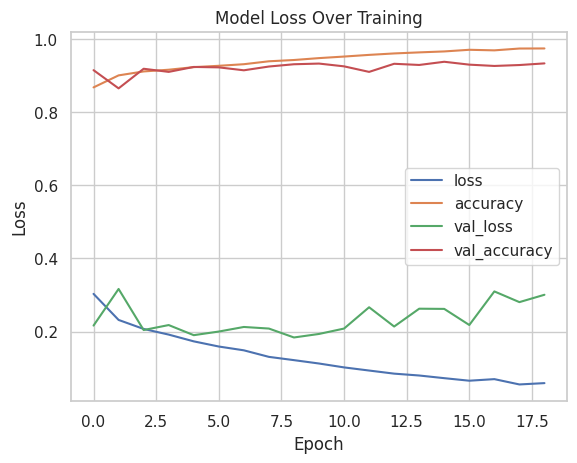

In [14]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [15]:
predictions = (final_model.predict(X_val) > 0.5).astype(int) # binary classification

counter = 0
for x,y in zip(y_val,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_val))

mcc = matthews_corrcoef(y_val, predictions)

print("MCC Score:", mcc)

437/437 [==============================] - 1s 2ms/step
Correct predictions:  13043
Total samples predicted: 13960
MCC Score: 0.7982307656799179


In [16]:
report = classification_report(y_val, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     11124
           1       0.83      0.85      0.84      2836

    accuracy                           0.93     13960
   macro avg       0.90      0.90      0.90     13960
weighted avg       0.93      0.93      0.93     13960


In [17]:
final_model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/1512_fnn_bin_v1.keras")


In [51]:
print(len(y_val))

5762


# Pretty ROC

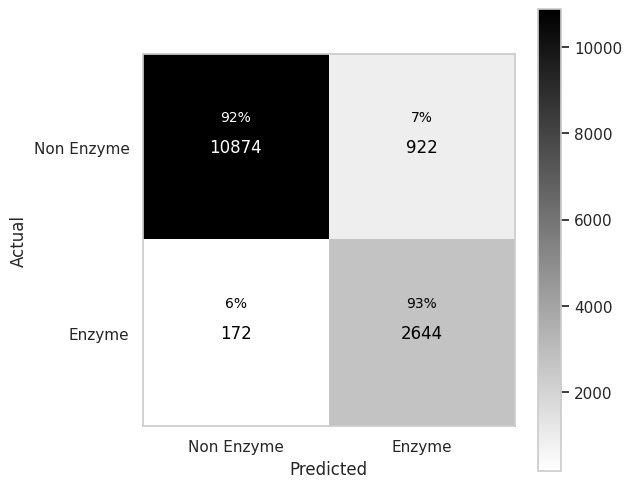

In [29]:
class_names = ["Non Enzyme", "Enzyme"]
conf_matrix = confusion_matrix(y_val, predictions)

# Calculate the percentages
cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(2):
    for j in range(2):
        
        # Increase the vertical offset for the percentage text
        offset = 0.2
        text_color = cax.texts[i * 2 + j].get_color()
        ax.text(j, i - offset, f'{int(cm_percentage[i, j])}%', ha='center', va='top', color=text_color, fontsize=10, fontweight='light', zorder=4)
        
        
# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)

plt.show()

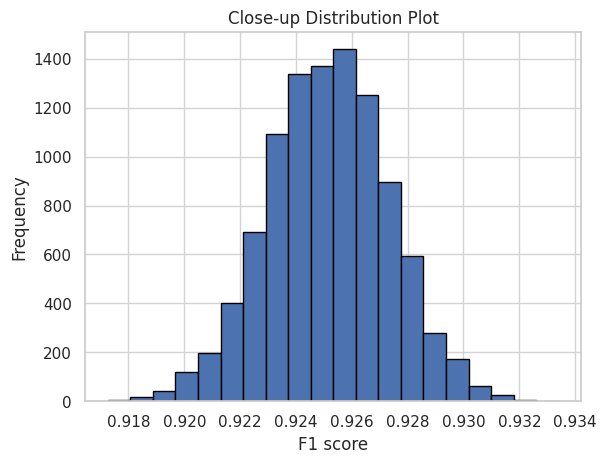

Multiclass CNN:
  - Initial F1 Score: 0.93
  - Mean ± SE: 0.925 ± 0.0022
  - 95% CI: [0.92, 0.93]


In [30]:
def bootstrap_statistic(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score = statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)

    # Set the range of values you want to plot (e.g., between 0.70 and 0.74)
    min_value = 0.9
    max_value = 0.96

    # Filter data within the specified range
    filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

    # Create the histogram
    plt.hist(filtered_data, bins=20, edgecolor='black')

    # Set the title and labels
    # Set the background color to white
    plt.gca().set_facecolor('white')

    # Set the grid color to black
    plt.grid(color='lightgrey')
    plt.title('Close-up Distribution Plot')
    plt.xlabel('F1 score')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)


def round_to_significance(x, significance):
    if significance == 0.0:
        sig_position = 0
    else:
        sig_position = int(math.floor(math.log10(abs(significance))))
    return round(x, -sig_position), round(significance, -sig_position + 1)


def train_and_predict(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    return clf.predict(X_test)


def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')


initial_f1 = calculate_f1(y_val, predictions)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_val, predictions, calculate_f1)

rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

print(f"Multiclass CNN:")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
